# Mapping analysis with BART

CD - AB correlate with cosine distance between models

ROI method: lasso or something predicting the distances within each ROI (I remember every part of the brain was significant when searchlighting the correlation...

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [3]:
import json
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == 'darwin':
    cfg = os.path.join("/Users", "njchiang", "CloudStation", "Grad",
                       "Research", "montilab-ucla", "analogy", "config", "project.json")
    plat = "osx"

elif sys.platform == "linux":
    import platform
    if platform.linux_distribution()[0] == "debian":
        cfg = os.path.join("/home", "njchiang", "data", "CloudStation", "Grad",
                           "Research", "montilab-ucla", "analogy", "config", "project.json")
        plat = "linux"
    else:
        cfg = os.path.join("/u", "project", "monti", "Analysis", "Analogy",
                           "code", "analogy", "config", "project.json")
        plat = "hoff"
else:
    cfg = os.path.join("D:\\", "CloudStation", "Grad",
                       "Research", "montilab-ucla", "analogy", "config", "project.json")
    plat = "win"

with open(cfg, "r") as f:
    projectSettings = json.load(f)

paths = projectSettings["filepaths"]["{}Paths".format(plat)]
sys.path.append(paths["github"])
sys.path.append(paths["code"])

In [4]:
from fmri.analogy_utils import analysisSettings, contrastSettings, order, \
    pu, pa, pv, compile_models, rsa, save_rois, load_rois, load_betas


Loading JSON config from /u/project/monti/Analysis/Analogy/code/analogy/config/analyses.json
Loading JSON config from /u/project/monti/Analysis/Analogy/code/analogy/config/contrasts.json
Loading label file from: /u/project/monti/Analysis/Analogy/code/analogy/labels/trialorder_rsa_absorted.csv


In [5]:
from fmri.analogy_rsa import \
downsample_rdms_df_by_factor, create_models, models_to_df, plotmodels,\
roi_rdm, run_rsa_dfs, subject_rdms, plot_results

In [6]:
masks_dict = analysisSettings["roi"]["masks"]
masks_dict["rlpfc-hobeika"] = "anat-left-rlpfc-hobeika2016"
masks_dict["rlpfc-power"] = "anat-left-rlpfc-power2011"
masks_dict["dlpfc-power"] = "anat-left-dlpfc-power2011"
masks_dict["vlpfc-power"] = "anat-left-vlpfc-power2011"
masks_dict["spl-power"] = "anat-left-spl-power2011"
masks_dict["ipl-power"] = "anat-left-ipl-power2011"

In [7]:
# b = "LSA"
# b = "pymvpa"
b = "cope-LSS"
# rois, labels = load_rois(b)
modelnames = ["w2vdiff", "concatword", 
              "rstpostprob9", "rstpostprob79"]
# modelnames = ["mainrel", "subrel", "rel", "humanratings"]

raw_models_df = pu.load_labels(os.path.join(paths["code"], "labels", "raw_models.csv"))


Loading label file from: /u/project/monti/Analysis/Analogy/code/analogy/labels/raw_models.csv


## Behavioral correlation

In [32]:
trials.TrialTag

0                     big:large::option:choice
2                         boat:ship::big:large
3                    boat:ship::pants:trousers
8                        couch:sofa::kid:child
10                cute:adorable::raise:elevate
12                       house:home::boat:ship
13                      house:home::run:sprint
14                 kid:child::make:manufacture
15                       kid:child::couch:sofa
18             option:choice::careful:cautious
20                  pants:trousers::spin:twirl
22                  pretty:beautiful::car:auto
23            pretty:beautiful::teach:instruct
24             raise:elevate::pretty:beautiful
25                raise:elevate::cute:adorable
28                      spin:twirl::house:home
32                book:magazine::ladder:stairs
34                      chair:sofa::pencil:pen
36                  fence:hedge::hill:mountain
37                fence:hedge::paper:parchment
40                   house:tent::book:magazine
42           

In [16]:
accuracies = pu.load_labels(paths["code"], "labels", "group_accuracy.csv").set_index("Trial")

Loading label file from: D:\CloudStation\Grad\Research\montilab-ucla\analogy\labels\group_accuracy.csv


In [18]:
 np.concatenate([accuracies.loc[t]["Group Acc"] for t in trials.TrialTag])

ValueError: zero-dimensional arrays cannot be concatenated

In [30]:
# behavioral_averages
# just run spearmanr
from scipy.stats import pearsonr
results = []
trials = order[order.ABMainRel == order.CDMainRel]
# trials = order[order.Probe != 0]

accuracies = pu.load_labels(paths["code"], "labels", "group_accuracy.csv").set_index("Trial")
for model in modelnames:
    print("Running {}".format(model))
    # select model this way # keys .isin
    model_df = (raw_models_df[::2]
                .reset_index(drop=True)
                .set_index("ABTag")[
                    [c for c in raw_models_df.columns if model in c]
                ])  
    dists = np.concatenate(
        [rsa.pdist(model_df.loc[
            [t.split("::")[0], t.split("::")[1]]], 
               metric="cosine") 
         for t in trials.TrialTag])
    
    accs = np.array(
        [accuracies.loc[t]["Group Acc"] for t in trials.TrialTag]
    )
#     results.append(rsa.spearmanr(accs, dists))
    results.append(pearsonr(accs, dists))

results

Loading label file from: D:\CloudStation\Grad\Research\montilab-ucla\analogy\labels\group_accuracy.csv
Running w2vdiff
Running concatword
Running rstpostprob9
Running rstpostprob79


[(-0.09629789720831587, 0.2508967260391337),
 (-0.23511954024442838, 0.004557903742077567),
 (-0.24430426881987888, 0.003167977748057288),
 (-0.1521423908369788, 0.06869667669604021)]

In [33]:
# behavioral_averages
# just run spearmanr
from scipy.stats import pearsonr
results = []
trials = order[order.ABMainRel != order.CDMainRel]
# trials = order[order.Probe != 0]

accuracies = pu.load_labels(paths["code"], "labels", "group_accuracy.csv").set_index("Trial")
for model in modelnames:
    print("Running {}".format(model))
    # select model this way # keys .isin
    model_df = (raw_models_df[::2]
                .reset_index(drop=True)
                .set_index("ABTag")[
                    [c for c in raw_models_df.columns if model in c]
                ])  
    dists = np.concatenate(
        [rsa.pdist(model_df.loc[
            [t.split("::")[0], t.split("::")[1]]], 
               metric="cosine") 
         for t in trials.TrialTag])
    
    accs = np.array(
        [accuracies.loc[t]["Group Acc"] for t in trials.TrialTag]
    )
#     results.append(rsa.spearmanr(accs, dists))
    results.append(pearsonr(accs, dists))

results

Loading label file from: D:\CloudStation\Grad\Research\montilab-ucla\analogy\labels\group_accuracy.csv
Running w2vdiff
Running concatword
Running rstpostprob9
Running rstpostprob79


[(0.04763406969891013, 0.5707488298471897),
 (0.17242893936718812, 0.03877004856860249),
 (0.027973978897863225, 0.7392646970080734),
 (0.035223340415547526, 0.6751237907559898)]

## Voxelwise correlation

In [22]:
# mask data graymatter
# sub = "sub-01"
maskname = "graymatter"

for sub in projectSettings["subjects"]:
    mask = pu.load_img(paths["root"], "derivatives", sub, "masks", "{}.nii.gz".format(maskname))

    fmri_data, labels, bg_image = load_betas(projectSettings, sub, t=b, center=True, scale=False)

    fmri_data = pu.mask_img(fmri_data, mask)
    
    trials = labels[(labels.CD == 1) & (labels.Match == "1")]
    
    fmri_data = fmri_data[trials.index]
    
#     fmri_data = fmri_data[trials.index] - fmri_data[trials.index - 1]

#     fmri_data = fmri_data[labels[labels.Probe == 0].index]

#     fmri_data = fmri_data[1::2] - fmri_data[::2]  # double check this


    for model in modelnames:
        print("Running {} | {}".format(sub, model))
        # select model this way # keys .isin
        model_df = (raw_models_df[::2]
                    .reset_index(drop=True)
                    .set_index("ABTag")[
                        [c for c in raw_models_df.columns if model in c]
                    ])  
        dists = np.concatenate(
            [rsa.pdist(model_df.loc[
                [t.split("::")[0], t.split("::")[1]]], 
                   metric="cosine") 
             for t in trials.TrialTag])

        results = np.array([np.corrcoef(fmri_data[:, v], dists)[0, 1] for v in range(fmri_data.shape[1])])

        pu.unmask_img(results, mask).to_filename(
            os.path.join(paths["root"], "analysis", sub, 
                         "encoding", "{}-{}-{}_CDMatch.nii.gz".format(sub, model, b)))

Reading file from: D:\fmri\Analogy\derivatives\sub-01\masks\graymatter.nii.gz
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-01_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-02_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-06_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-07_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_t

C:\tools\miniconda3\envs\research\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\tools\miniconda3\envs\research\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


unmasking image...
Running sub-01 | concatword
unmasking image...
Running sub-01 | rstpostprob9
unmasking image...
Running sub-01 | rstpostprob79
unmasking image...
Reading file from: D:\fmri\Analogy\derivatives\sub-02\masks\graymatter.nii.gz
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-01_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-02_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-06_events.csv
centering image
Loading label file from: D:

Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-01_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-02_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-06_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-07_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-08\func\sub-08_task-analogy_run-08_events.csv
Concatenating 8 images
Reading file from: D:\fmri\Analogy\deriva

Loading label file from: D:\fmri\Analogy\derivatives\sub-14\func\sub-14_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-14\func\sub-14_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-14\func\sub-14_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-14\func\sub-14_task-analogy_run-06_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-14\func\sub-14_task-analogy_run-07_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-14\func\sub-14_task-analogy_run-08_events.csv
Concatenating 8 images
Reading file from: D:\fmri\Analogy\derivatives\sub-14\reg\BOLD_template.nii.gz
Applying mask
Running sub-14 | w2vdiff
unmasking image...
Running sub-14 | concatword
unmasking image...
Running sub-14 | rstpostprob9
unmasking image...
Running sub-14 | rstpostprob79
unmasking image

In [24]:
# mask data graymatter
# sub = "sub-01"
maskname = "graymatter"

for sub in projectSettings["subjects"]:
    mask = pu.load_img(paths["root"], "derivatives", sub, "masks", "{}.nii.gz".format(maskname))

    fmri_data, labels, bg_image = load_betas(projectSettings, sub, t=b, center=True, scale=False)

    fmri_data = pu.mask_img(fmri_data, mask)
    
    trials = labels[(labels.CD == 1) & (labels.Match == "1")]
    
    fmri_data = fmri_data[trials.index]
    
#     fmri_data = fmri_data[trials.index] - fmri_data[trials.index - 1]

#     fmri_data = fmri_data[labels[labels.Probe == 0].index]

#     fmri_data = fmri_data[1::2] - fmri_data[::2]  # double check this

    model = "accuracy"
    
    print("Running {} | {}".format(sub, model))
    # select model this way # keys .isin
#     model_df = (raw_models_df[::2]
#                 .reset_index(drop=True)
#                 .set_index("ABTag")[
#                     [c for c in raw_models_df.columns if model in c]
#                 ])  
#         dists = np.concatenate(
#             [rsa.pdist(model_df.loc[
#                 [t.split("::")[0], t.split("::")[1]]], 
#                    metric="cosine") 
#              for t in trials.TrialTag])

    dists = np.array(
        [accuracies.loc[t]["Group Acc"] for t in trials.TrialTag]
    )

    results = np.array([np.corrcoef(fmri_data[:, v], dists)[0, 1] for v in range(fmri_data.shape[1])])

    pu.unmask_img(results, mask).to_filename(
        os.path.join(paths["root"], "analysis", sub, 
                     "encoding", "{}-{}-{}_CDMatch.nii.gz".format(sub, model, b)))

Reading file from: D:\fmri\Analogy\derivatives\sub-01\masks\graymatter.nii.gz
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-01_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-02_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-06_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_task-analogy_run-07_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-01\func\sub-01_t

C:\tools\miniconda3\envs\research\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\tools\miniconda3\envs\research\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


unmasking image...
Reading file from: D:\fmri\Analogy\derivatives\sub-02\masks\graymatter.nii.gz
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-01_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-02_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-06_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-02\func\sub-02_task-analogy_run-07_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\s

Reading file from: D:\fmri\Analogy\derivatives\sub-08\reg\BOLD_template.nii.gz
Applying mask
Running sub-08 | accuracy
unmasking image...
Reading file from: D:\fmri\Analogy\derivatives\sub-09\masks\graymatter.nii.gz
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-09\func\sub-09_task-analogy_run-01_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-09\func\sub-09_task-analogy_run-02_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-09\func\sub-09_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-09\func\sub-09_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-09\func\sub-09_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-09\func\sub-09_task-analogy_run-06_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\s

Loading label file from: D:\fmri\Analogy\derivatives\sub-15\func\sub-15_task-analogy_run-08_events.csv
Concatenating 8 images
Reading file from: D:\fmri\Analogy\derivatives\sub-15\reg\BOLD_template.nii.gz
Applying mask
Running sub-15 | accuracy
unmasking image...
Reading file from: D:\fmri\Analogy\derivatives\sub-16\masks\graymatter.nii.gz
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-16\func\sub-16_task-analogy_run-01_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-16\func\sub-16_task-analogy_run-02_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-16\func\sub-16_task-analogy_run-03_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-16\func\sub-16_task-analogy_run-04_events.csv
centering image
Loading label file from: D:\fmri\Analogy\derivatives\sub-16\func\sub-16_task-analogy_run-05_events.csv
centering image
Loading label file from: D:\fmri\Analogy\deriva

Helper functions to compile models in the same order as the participants saw them

In [25]:
%%bash
cd ~/data/fmri/Analogy
sel=CDMatch
for m in accuracy # rstpostprob79 rstpostprob9 w2vdiff concatword
do
  echo ${m}
  for s in 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16
  do
    echo sub-${s}
      flirt -in analysis/sub-${s}/encoding/sub-${s}-${m}-cope-LSS_${sel} \
      -out analysis/group/encoding/sub-${s}_${m}_${sel} \
      -ref derivatives/standard/MNI152_T1_2mm_brain.nii.gz \
      -applyxfm -init derivatives/sub-${s}/reg/BOLD_template_to_standard.mat  
  done
  fslmerge -t analysis/group/encoding/group-cdmatch_${m}.nii.gz analysis/group/encoding/sub*_${m}_${sel}.nii.gz
  rm analysis/group/encoding/sub*_${m}_${sel}.nii.gz
done


accuracy
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16


In [26]:
%%bash
n=1000
cd ~/data/fmri/Analogy

for m in accuracy # rstpostprob79 rstpostprob9 w2vdiff concatword
do
    randomise -i analysis/group/encoding/group-cdmatch_${m} \
      -o analysis/group/encoding/n${n}-CD_${m} \
      -m derivatives/standard/masks/grayMatter \
      -n ${n} -1 -T --uncorrp -v 10
done


randomise options: -i analysis/group/encoding/group-cdmatch_accuracy -o analysis/group/encoding/n1000-CD_accuracy -m derivatives/standard/masks/grayMatter -n 1000 -1 -T --uncorrp -v 10 
Loading Data: 
Data loaded
One-sample design detected; sign-flipping instead of permuting.
65536 sign-flips required for exhaustive test of t-test 1
Doing 1000 random permutations
Starting permutation 1 (Unpermuted data)
Starting permutation 2
Starting permutation 3
Starting permutation 4
Starting permutation 5
Starting permutation 6
Starting permutation 7
Starting permutation 8
Starting permutation 9
Starting permutation 10
Starting permutation 11
Starting permutation 12
Starting permutation 13
Starting permutation 14
Starting permutation 15
Starting permutation 16
Starting permutation 17
Starting permutation 18
Starting permutation 19
Starting permutation 20
Starting permutation 21
Starting permutation 22
Starting permutation 23
Starting permutation 24
Starting permutation 25
Starting permutation 26
S

In [16]:
%%bash
n=1000
cd ~/data/fmri/Analogy

for m in rstpostprob79 rstpostprob9 w2vdiff concatword
do
    randomise -i analysis/group/encoding/group-cdnomatch_${m} \
      -o analysis/group/encoding/n${n}-CDNoMatch_${m} \
      -m derivatives/standard/masks/grayMatter \
      -n ${n} -1 -T --uncorrp -v 10
done

randomise options: -i analysis/group/encoding/group-cdnomatch_rstpostprob79 -o analysis/group/encoding/n1000-CDNoMatch_rstpostprob79 -m derivatives/standard/masks/grayMatter -n 1000 -1 -T --uncorrp -v 10 
Loading Data: 
Data loaded
One-sample design detected; sign-flipping instead of permuting.
65536 sign-flips required for exhaustive test of t-test 1
Doing 1000 random permutations
Starting permutation 1 (Unpermuted data)
Starting permutation 2
Starting permutation 3
Starting permutation 4
Starting permutation 5
Starting permutation 6
Starting permutation 7
Starting permutation 8
Starting permutation 9
Starting permutation 10
Starting permutation 11
Starting permutation 12
Starting permutation 13
Starting permutation 14
Starting permutation 15
Starting permutation 16
Starting permutation 17
Starting permutation 18
Starting permutation 19
Starting permutation 20
Starting permutation 21
Starting permutation 22
Starting permutation 23
Starting permutation 24
Starting permutation 25
Starti

## ROI (mean) correlation

In [8]:
# ROI

rois, labels = load_rois(b)
result_dfs = []
for model in modelnames:
    print(model)
    results = {}
    for m in masks_dict:
        results[m] = []
        for sub in projectSettings["subjects"]:
            label = labels[sub]
            roi = rois[sub][m]
            selector = label[(label.CD == 1) & (label.Match == "1")]
#             selector = label[(label.CD == 1) & (label.Match == "0")]
#             selector = label[(label.CD == 1)]


            model_df = (raw_models_df[::2]
                                .reset_index(drop=True)
                                .set_index("ABTag")[
                                    [c for c in raw_models_df.columns if model in c]
                                ])  
            dists = np.concatenate(
                [rsa.pdist(model_df.loc[
                    [t.split("::")[0], t.split("::")[1]]], 
                       metric="cosine") 
                 for t in selector.TrialTag])

            results[m].append(rsa.spearmanr(roi[selector.index].mean(1), dists)[0])
            # roi[selector.index].mean(1).shape, dists.shape
    result_dfs.append(pd.DataFrame(results))
#         print(m, rsa.wilcoxon_onesided(results[m]))


Loading sub-01 betas
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/rois/sub-01_cope-LSS_labels.csv
Loading sub-02 betas
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-02/rois/sub-02_cope-LSS_labels.csv
Loading sub-03 betas
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-03/rois/sub-03_cope-LSS_labels.csv
Loading sub-04 betas
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-04/rois/sub-04_cope-LSS_labels.csv
Loading sub-05 betas
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-05/rois/sub-05_cope-LSS_labels.csv
Loading sub-06 betas
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-06/rois/sub-06_cope-LSS_labels.csv
Loading sub-07 betas
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-07/rois/sub-07_cope-LSS_labels.csv
Loading sub-08 betas
Loading label file from: /u/project/monti/Analysis/Analogy/der

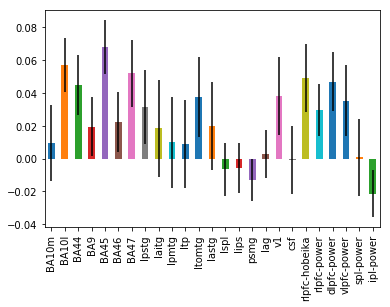

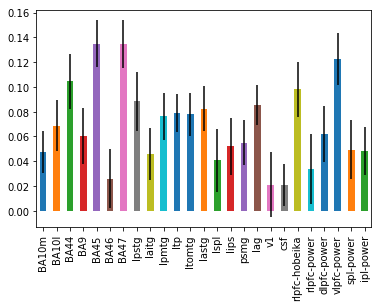

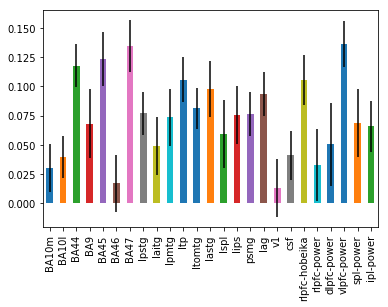

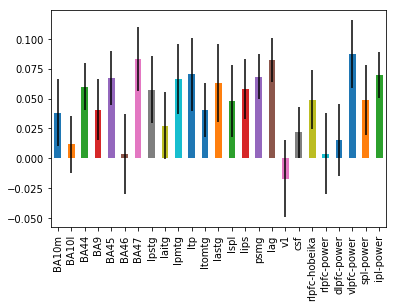

In [10]:
for r in [result_dfs[1], result_dfs[3], result_dfs[3]-result_dfs[0], result_dfs[3]-result_dfs[1]]:
    plt.figure()
    r.mean().plot(kind="bar", yerr = r.std()/np.sqrt(15))

In [13]:
pd.concat([result_dfs[i].std()/np.sqrt(15).T for i in range(len(result_dfs))], axis=1)

,0,1,2,3
BA10m,0.015820,0.022989,0.023865,0.017009
BA10l,0.011209,0.016254,0.026550,0.020639
BA44,0.011152,0.018304,0.020951,0.022215
BA9,0.016489,0.017827,0.025844,0.022609
BA45,0.015994,0.016462,0.020686,0.018871
BA46,0.013998,0.018236,0.024248,0.023632
BA47,0.015874,0.020272,0.020630,0.019322
lpstg,0.017265,0.022591,0.025388,0.023894
laitg,0.024084,0.029626,0.023163,0.021027
lpmtg,0.023152,0.027476,0.024407,0.019270


In [20]:
means = pd.concat([result_dfs[i].mean() for i in range(4)], axis=1).T
stds = pd.concat([result_dfs[i].std()/np.sqrt(15) for i in range(4)], axis=1).T

In [11]:
from statsmodels.stats.multitest import multipletests

In [36]:
multipletests([1,2,3,4,5])

(array([False, False, False, False, False]),
 array([1., 1., 1., 1., 1.]),
 0.010206218313011495,
 0.01)

In [12]:
raw_ps = pd.concat([result_dfs[i].apply(rsa.wilcoxon_onesided) for i in range(4)], axis=1)

In [14]:
raw_ps.T.apply(lambda x: multipletests(x)[1]).T

,0,1,2,3
BA10m,0.288598,0.660442,0.488413,0.022381
BA10l,0.019871,0.009172,0.019871,0.006394
BA44,0.901946,0.029650,0.002690,0.002690
BA9,0.795978,0.278396,0.019310,0.022458
BA45,0.250724,0.002706,0.000964,0.000875
BA46,0.467943,0.420875,0.581931,0.467943
BA47,0.602006,0.026012,0.001062,0.001062
lpstg,0.732537,0.203088,0.004056,0.003832
laitg,0.807840,0.807840,0.266261,0.119573
lpmtg,0.621816,0.538728,0.064175,0.007545


In [16]:
hypotheses = ["BA10m", "BA10l", "BA44", "BA9", "BA45", "BA46", "BA47", "lspl", "lips", "psmg", "lag"]


In [28]:
sub_ps = pd.concat([bartvw2vc, bartvw2vd], axis=1)
sub_ps

,0,1
BA10m,0.089405,0.107301
BA10l,0.500000,0.011447
BA44,0.005643,0.000388
BA9,0.039365,0.017001
BA45,0.007543,0.000673
BA46,0.697453,0.641310
BA47,0.004180,0.000468
lpstg,0.043968,0.001354
laitg,0.267463,0.035163
lpmtg,0.017001,0.004180


In [37]:
# corrp by hypotehsis
bartvw2vd = (result_dfs[3] - result_dfs[0]).apply(rsa.wilcoxon_onesided)
bartvw2vc = (result_dfs[3] - result_dfs[1]).apply(rsa.wilcoxon_onesided)
sub_ps = pd.concat([bartvw2vc, bartvw2vd], axis=1)
# pd.DataFrame(sub_ps)
# print(multipletests(sub_ps)[1])
sub_ps.T.apply(lambda x: multipletests(x)[1], axis=0).T

,0,1
BA10m,0.170817,0.170817
BA10l,0.500000,0.022764
BA44,0.005643,0.000776
BA9,0.039365,0.033712
BA45,0.007543,0.001346
BA46,0.871341,0.871341
BA47,0.004180,0.000935
lpstg,0.043968,0.002706
laitg,0.267463,0.069089
lpmtg,0.017001,0.008343


In [38]:
(sub_ps).loc[hypotheses].apply(lambda x: multipletests(x)[1], axis=0)

,0,1
BA10m,0.287761,0.203088
BA10l,0.750000,0.055941
BA44,0.044261,0.004262
BA9,0.181929,0.066288
BA45,0.051620,0.006042
BA46,0.750000,0.641310
BA47,0.037000,0.004666
lspl,0.287761,0.101823
lips,0.155939,0.033383
psmg,0.015908,0.011162


In [9]:
for model in modelnames:
    print(model)
    results = {}
    for m in analysisSettings["roi"]["masks"]:
        results[m] = []
        for sub in projectSettings["subjects"]:
            label = labels[sub]
            roi = rois[sub][m]
        #     selector = label[(label.CD == 1) & (label.Match == "1")]
#             selector = label[(label.CD == 1) & (label.Match == "0")]
            selector = label[(label.CD == 1)]


            model_df = (raw_models_df[::2]
                                .reset_index(drop=True)
                                .set_index("ABTag")[
                                    [c for c in raw_models_df.columns if model in c]
                                ])  
            dists = np.concatenate(
                [rsa.pdist(model_df.loc[
                    [t.split("::")[0], t.split("::")[1]]], 
                       metric="cosine") 
                 for t in selector.TrialTag])

            results[m].append(rsa.spearmanr(roi[selector.index].mean(1), dists)[0])
            # roi[selector.index].mean(1).shape, dists.shape
        print(m, rsa.wilcoxon_onesided(results[m]))


w2vdiff
ba10 0.30254747322700604
ba44 0.8723547474001925
ba45 0.4793803749689914
ba46 0.10730094314595479
ba47 0.8240105791643191
lpstg 0.7152528610041406
laitg 0.9455295642114426
lpmtg 0.9781335561916427
ltp 0.9686643060655188
ltomtg 0.8926990568540452
lastg 0.933135053567741
lips 0.8103126655955601
lag 0.8926990568540452
v1 0.13876512529757257
csf 0.5411842032664956
concatword
ba10 0.9721403378236244
ba44 0.8723547474001925
ba45 0.17598942083568098
ba46 0.6020063923056863
ba47 0.8828395141311591
lpstg 0.7152528610041406
laitg 0.926169872219175
lpmtg 0.960634594401933
ltp 0.9455295642114426
ltomtg 0.9186633424640266
lastg 0.79597789715644
lips 0.9829994872993032
lag 0.992457087877732
v1 0.30254747322700604
csf 0.8240105791643191
rstpostprob9
ba10 0.9869081759514656
ba44 0.009985437712802837
ba45 0.004862761770819823
ba46 0.7325373934307802
ba47 0.03936540559806701
lpstg 0.014936572009614516
laitg 0.8240105791643191
lpmtg 0.8494729091887006
ltp 0.660442155353592
ltomtg 0.26746260656921

In [11]:
for model in modelnames:
    print(model)
    results = {}
    for m in analysisSettings["roi"]["masks"]:
        results[m] = []
        for sub in projectSettings["subjects"]:
            label = labels[sub]
            roi = rois[sub][m]
#             selector = label[(label.CD == 1) & (label.Match == "1")]
            selector = label[(label.CD == 1) & (label.Match == "0")]
#             selector = label[(label.CD == 1)]


            model_df = (raw_models_df[::2]
                                .reset_index(drop=True)
                                .set_index("ABTag")[
                                    [c for c in raw_models_df.columns if model in c]
                                ])  
            dists = np.concatenate(
                [rsa.pdist(model_df.loc[
                    [t.split("::")[0], t.split("::")[1]]], 
                       metric="cosine") 
                 for t in selector.TrialTag])

            results[m].append(rsa.spearmanr(roi[selector.index].mean(1), dists)[0])
            # roi[selector.index].mean(1).shape, dists.shape
        print(m, rsa.wilcoxon_onesided(results[m]))


w2vdiff
ba10 0.5616391283825543
ba44 0.660442155353592
ba45 0.43836087161744575
ba46 0.10730094314595479
ba47 0.2847471389958594
lpstg 0.9019459069529063
laitg 0.26746260656921983
lpmtg 0.660442155353592
ltp 0.3979936076943137
ltomtg 0.2507237357435369
lastg 0.9105949867686274
lips 0.45881579673350437
lag 0.031335693934481226
v1 0.5819306691294794
csf 0.13876512529757257
concatword
ba10 0.7325373934307802
ba44 0.9913108182766509
ba45 0.9996117942504681
ba46 0.6791699366976678
ba47 0.9913108182766509
lpstg 0.7654434237822729
laitg 0.7325373934307802
lpmtg 0.3781844314405348
ltp 0.926169872219175
ltomtg 0.9973830454046059
lastg 0.975289016510162
lips 0.975289016510162
lag 0.9019459069529063
v1 0.933135053567741
csf 0.6218155685594652
rstpostprob9
ba10 0.9105949867686274
ba44 0.7152528610041406
ba45 0.3781844314405348
ba46 0.7810167124169898
ba47 0.33955784464640804
lpstg 0.3979936076943137
laitg 0.7654434237822729
lpmtg 0.6413095557928394
ltp 0.5819306691294794
ltomtg 0.5
lastg 0.6413095

In [12]:
for model in modelnames:
    print(model)
    results = {}
    for m in analysisSettings["roi"]["masks"]:
        results[m] = []
        for sub in projectSettings["subjects"]:
            label = labels[sub]
            roi = rois[sub][m]
        #     selector = label[(label.CD == 1) & (label.Match == "1")]
#             selector = label[(label.CD == 1) & (label.Match == "0")]
            selector = label[(label.CD == 1)]


            model_df = (raw_models_df[::2]
                                .reset_index(drop=True)
                                .set_index("ABTag")[
                                    [c for c in raw_models_df.columns if model in c]
                                ])  
            dists = np.concatenate(
                [rsa.pdist(model_df.loc[
                    [t.split("::")[0], t.split("::")[1]]], 
                       metric="cosine") 
                 for t in selector.TrialTag])

            results[m].append(rsa.spearmanr(roi[selector.index].mean(1) -
                                            roi[selector.index-1].mean(1), 
                                            dists)[0])
            # roi[selector.index].mean(1).shape, dists.shape
        print(m, rsa.wilcoxon_onesided(results[m]))


w2vdiff
ba10 0.20402210284355998
ba44 0.6218155685594652
ba45 0.21898328758301028
ba46 0.32083006330233227
ba47 0.4180693308705205
lpstg 0.20402210284355998
laitg 0.6020063923056863
lpmtg 0.9019459069529063
ltp 0.660442155353592
ltomtg 0.5411842032664956
lastg 0.43836087161744575
lips 0.7325373934307802
lag 0.17598942083568098
v1 0.7654434237822729
csf 0.32083006330233227
concatword
ba10 0.7152528610041406
ba44 0.6020063923056863
ba45 0.660442155353592
ba46 0.21898328758301028
ba47 0.697452526772994
lpstg 0.06686494643225907
laitg 0.3781844314405348
lpmtg 0.697452526772994
ltp 0.5
ltomtg 0.7325373934307802
lastg 0.6791699366976678
lips 0.3781844314405348
lag 0.5206196250310087
v1 0.5411842032664956
csf 0.7152528610041406
rstpostprob9
ba10 0.9105949867686274
ba44 0.2507237357435369
ba45 0.33955784464640804
ba46 0.7152528610041406
ba47 0.6218155685594652
lpstg 0.4180693308705205
laitg 0.9105949867686274
lpmtg 0.933135053567741
ltp 0.8926990568540452
ltomtg 0.9781335561916427
lastg 0.4588

In [13]:
for model in modelnames:
    print(model)
    results = {}
    for m in analysisSettings["roi"]["masks"]:
        results[m] = []
        for sub in projectSettings["subjects"]:
            label = labels[sub]
            roi = rois[sub][m]
        #     selector = label[(label.CD == 1) & (label.Match == "1")]
            selector = label[(label.CD == 1) & (label.Match == "0")]
#             selector = label[(label.CD == 1)]


            model_df = (raw_models_df[::2]
                                .reset_index(drop=True)
                                .set_index("ABTag")[
                                    [c for c in raw_models_df.columns if model in c]
                                ])  
            dists = np.concatenate(
                [rsa.pdist(model_df.loc[
                    [t.split("::")[0], t.split("::")[1]]], 
                       metric="cosine") 
                 for t in selector.TrialTag])

            results[m].append(rsa.spearmanr(roi[selector.index].mean(1) -
                                            roi[selector.index-1].mean(1), 
                                            dists)[0])
            # roi[selector.index].mean(1).shape, dists.shape
        print(m, rsa.wilcoxon_onesided(results[m]))


w2vdiff
ba10 0.6020063923056863
ba44 0.10730094314595479
ba45 0.16293501214848982
ba46 0.33955784464640804
ba47 0.5616391283825543
lpstg 0.45881579673350437
laitg 0.32083006330233227
lpmtg 0.8723547474001925
ltp 0.17598942083568098
ltomtg 0.32083006330233227
lastg 0.5206196250310087
lips 0.3979936076943137
lag 0.02186644380835736
v1 0.9105949867686274
csf 0.13876512529757257
concatword
ba10 0.5819306691294794
ba44 0.20402210284355998
ba45 0.8926990568540452
ba46 0.6218155685594652
ba47 0.697452526772994
lpstg 0.10730094314595479
laitg 0.5819306691294794
lpmtg 0.2507237357435369
ltp 0.2507237357435369
ltomtg 0.8240105791643191
lastg 0.43836087161744575
lips 0.8494729091887006
lag 0.16293501214848982
v1 0.8103126655955601
csf 0.8494729091887006
rstpostprob9
ba10 0.7492762642564631
ba44 0.933135053567741
ba45 0.7325373934307802
ba46 0.8723547474001925
ba47 0.7325373934307802
lpstg 0.660442155353592
laitg 0.933135053567741
lpmtg 0.8103126655955601
ltp 0.8612348747024274
ltomtg 0.8723547474

In [14]:
for model in modelnames:
    print(model)
    results = {}
    for m in analysisSettings["roi"]["masks"]:
        results[m] = []
        for sub in projectSettings["subjects"]:
            label = labels[sub]
            roi = rois[sub][m]
            selector = label[(label.CD == 1) & (label.Match == "1")]
#             selector = label[(label.CD == 1) & (label.Match == "0")]
#             selector = label[(label.CD == 1)]


            model_df = (raw_models_df[::2]
                                .reset_index(drop=True)
                                .set_index("ABTag")[
                                    [c for c in raw_models_df.columns if model in c]
                                ])  
            dists = np.concatenate(
                [rsa.pdist(model_df.loc[
                    [t.split("::")[0], t.split("::")[1]]], 
                       metric="cosine") 
                 for t in selector.TrialTag])

            results[m].append(rsa.spearmanr(roi[selector.index].mean(1) -
                                            roi[selector.index-1].mean(1), 
                                            dists)[0])
            # roi[selector.index].mean(1).shape, dists.shape
        print(m, rsa.wilcoxon_onesided(results[m]))


w2vdiff
ba10 0.02186644380835736
ba44 0.660442155353592
ba45 0.18968733440443986
ba46 0.23455657621772708
ba47 0.26746260656921983
lpstg 0.03936540559806701
laitg 0.20402210284355998
lpmtg 0.16293501214848982
ltp 0.5411842032664956
ltomtg 0.32083006330233227
lastg 0.30254747322700604
lips 0.7492762642564631
lag 0.11716048586884081
v1 0.7152528610041406
csf 0.9686643060655188
concatword
ba10 0.1505270908112994
ba44 0.20402210284355998
ba45 0.054470435788557335
ba46 0.024710983489837978
ba47 0.09805409304709362
lpstg 0.11716048586884081
laitg 0.30254747322700604
lpmtg 0.4180693308705205
ltp 0.26746260656921983
ltomtg 0.08133665753597341
lastg 0.5819306691294794
lips 0.26746260656921983
lag 0.33955784464640804
v1 0.7325373934307802
csf 0.6218155685594652
rstpostprob9
ba10 0.5411842032664956
ba44 0.17598942083568098
ba45 0.024710983489837978
ba46 0.3586904442071606
ba47 0.005642787686764809
lpstg 0.09805409304709362
laitg 0.3586904442071606
lpmtg 0.2847471389958594
ltp 0.11716048586884081


## SCRATCH

In [ ]:
pa.rdm(np.array([models["concatword"][v] for v in order["full"].ABTag.values]))

In [ ]:
m = "concatword"
dists = np.array([rsa.pdist(np.vstack([models[m][tt.CDTag], 
                          models[m][tt.ABTag]]), metric="cosine") 
                                     for _, tt in order["full"].iterrows()]).squeeze()
dists

In [ ]:
# fdr output

# ba10
# ba44 + 45
# left aTG mask
# V1
# left IPS


In [ ]:
# run multivariate searchlight regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneGroupOut
modelnames = ["humanratings", "rel","rstpostprob79", "rstpostprob9", "w2vdiff", "concatword"]
analysisSettings["searchlight"]["estimator"] = LinearRegression()
cv = LeaveOneGroupOut()

maskname = "graymatter-bin_mask"
for sub in projectSettings["subjects"].keys():
    imgFile = os.path.join(paths['root'], 'derivatives', sub, 'betas', pu.format_bids_name(sub, 'task-analogy', 'betas-pymvpa.nii.gz'))
    mask = pu.load_img(paths['root'], 
                      'derivatives', sub, 'masks', 
                      maskname + '.nii.gz')
    img = pu.load_img(imgFile)


    labels = pu.load_labels(paths['root'], 
                           'derivatives', sub, 'betas', 
                           pu.format_bids_name(sub, 'task-analogy', 'events-pymvpa.tsv'), 
                           sep='\t', index_col=0)
    conditionSelector = np.where(labels['ab'] == 1)[0]

    img_ab = pu.data_to_img(img.get_data()[:,:,:, conditionSelector], img)
    img_ab.shape
    del img

    these_labels = labels.iloc[conditionSelector]
    sub_results = []
    for m in modelnames:
        this_model = pa.rdm(np.array([models[m][v] for v in these_labels.abtag.values]), metric="cosine")
        if m == "numchar":
            this_model = pa.rdm(np.array([models[m][v] for v in these_labels.abtag.values]))

        result= pa.searchlight_rsa(img_ab, this_model, m=mask)
        sub_results.append(result.scores_)

    pu.data_to_img(np.stack(sub_results, axis=3), img_ab).to_filename(
        os.path.join(paths["root"], "derivatives", sub, "rsa", "{}_{}_searchlight.nii.gz".format(sub, maskname)))
    result = pa.searchlight(img_ab, 
                            these_labels['abmainrel'], m=mask, cv=cv, 
                            groups=these_labels['chunks'],
                            **analysisSettings['searchlight'])
